In [1]:
#1) Automotive, Mobile, Sattelite

In [2]:
#2) Overfitting - Model learns the training data specific patterns instead of learning generic patterns, could be because of various reasons as less data, biased data etc

In [3]:
#3) Regularization, More Data, Hyperparameter tuning

In [4]:
#5) Load FMNIST dataset

In [2]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'


In [3]:
train_data = datasets.MNIST(root='.',train = True, download = True, transform = transforms.ToTensor())
test_data = datasets.MNIST(root='.',train = False, download = True, transform = transforms.ToTensor())

In [4]:
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: .
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: .
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [5]:
img,label = train_data[0][0],train_data[0][1]
img.shape,label

(torch.Size([1, 28, 28]), 5)

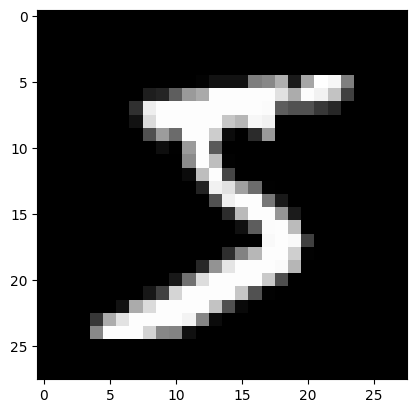

In [6]:
#plt.figure(figsize=(9,9))
#plt.imshow(img.squeeze(),cmap='gray')
plt.imshow(img.squeeze(),cmap='gray')

In [7]:
#6) Visualize at least 5 different samples of MNIST  dataset

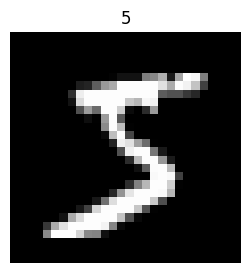

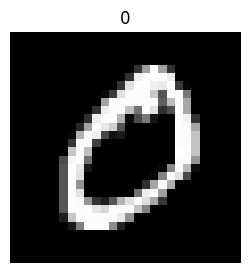

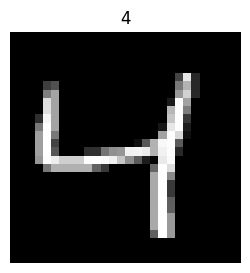

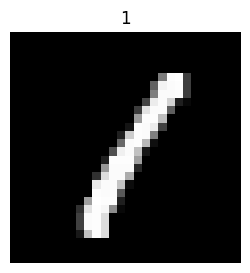

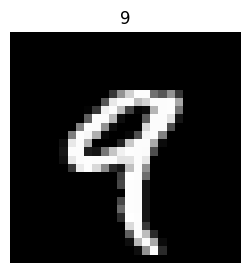

In [8]:

for i in range(5):
    img,label = train_data[i][0],train_data[i][1]
    plt.figure(figsize=(3,3))
    img_squeeze = img.squeeze()
    plt.imshow(img_squeeze,cmap='gray')
    plt.title(label)
    plt.axis(False)

In [9]:
#7) Turn into train/test data into dataloaders

In [10]:
train_dataloader = torch.utils.data.DataLoader(dataset = train_data,batch_size = 32,
                                              shuffle = True)
test_dataloader = torch.utils.data.DataLoader(dataset = test_data,batch_size = 32,
                                              shuffle = False)

In [11]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x11e5f2570>,
 <torch.utils.data.dataloader.DataLoader at 0x11e6ce0f0>)

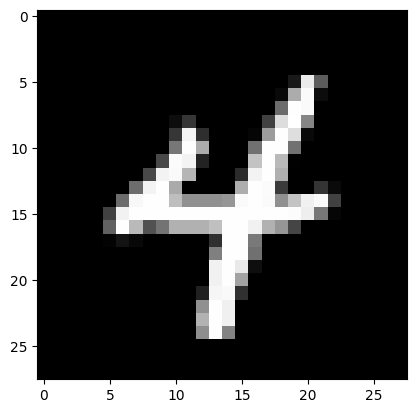

In [12]:
for batch_idx, (data, target) in enumerate(train_dataloader):
    # Process the data and target in each batch
    #print(batch_idx, data.shape, target.shape)
    for sample in next(iter(data)):
        if len(sample.shape) > 0:
            plt.imshow(sample.squeeze(),cmap='gray')
        else:
            plt.label(sample)
    image = iter(data)
    #print(next(image))
    break
    

In [13]:
#8) Recreate model_2

In [14]:
from torch import nn
class MNIST_MODEL(nn.Module):
    def __init__(self, in_units, hidden_units, out_units):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = in_units,
                     out_channels = hidden_units,
                     kernel_size = 3,
                     stride = 1,
                     padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                     out_channels = hidden_units,
                     kernel_size = 3,
                     stride = 1,
                     padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                     out_channels = hidden_units,
                     kernel_size = 3,
                     stride = 1,
                     padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                     out_channels = hidden_units,
                     kernel_size = 3,
                     stride = 1,
                     padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units*7*7,
                     out_features = out_units)
        )
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [15]:
model = MNIST_MODEL(in_units = 1, hidden_units = 10, out_units = 10).to(device)
model

MNIST_MODEL(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [16]:
#model.state_dict()

In [29]:

# Get the class names from the dataset
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [17]:
#9) Train model

In [18]:
%%time
from tqdm.auto import tqdm
model_cpu = MNIST_MODEL(in_units = 1, hidden_units = 10, out_units = 10).to('cpu')

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_cpu.parameters(), lr = 0.1)

#Training
epochs = 5

for epoch in tqdm(range(epochs)):
    train_loss = 0
    #print(f"Epoch:{epoch}")
    for batch,(X,y) in enumerate(train_dataloader):
        X,y = X.to('cpu'),y.to('cpu')
        model_cpu.train()
        y_logits = model_cpu(X)
        loss = loss_fn(y_logits,y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss/= len(train_dataloader)
    test_loss_total = 0
    model_cpu.eval()
    with torch.inference_mode():
        for batch, (X_test,y_test) in enumerate(test_dataloader):
            X_test,y_test = X_test.to('cpu'),y_test.to('cpu')
            test_logits = model_cpu(X_test)
            test_loss_total += loss_fn(test_logits, y_test)
        test_loss_total /= len(test_dataloader)
    print(f"Epoch: {epoch} | Loss :{train_loss:.3f} | Test Loss: {test_loss_total:.3f}")

/opt/anaconda3/envs/Pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 20%|██        | 1/5 [00:23<01:33, 23.49s/it]

Epoch: 0 | Loss :0.317 | Test Loss: 0.062


 40%|████      | 2/5 [00:46<01:10, 23.47s/it]

Epoch: 1 | Loss :0.068 | Test Loss: 0.050


 60%|██████    | 3/5 [01:10<00:46, 23.42s/it]

Epoch: 2 | Loss :0.052 | Test Loss: 0.046


 80%|████████  | 4/5 [01:33<00:23, 23.49s/it]

Epoch: 3 | Loss :0.043 | Test Loss: 0.040


100%|██████████| 5/5 [01:57<00:00, 23.42s/it]

Epoch: 4 | Loss :0.039 | Test Loss: 0.044
CPU times: user 13min 57s, sys: 1min 30s, total: 15min 27s
Wall time: 1min 57s


In [19]:
%%time
from tqdm.auto import tqdm
model_gpu = MNIST_MODEL(in_units = 1, hidden_units = 10, out_units = 10).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_cpu.parameters(), lr = 0.1)

#Training
epochs = 5

for epoch in tqdm(range(epochs)):
    train_loss = 0
    #print(f"Epoch:{epoch}")
    for batch,(X,y) in enumerate(train_dataloader):
        X,y = X.to(device),y.to(device)
        model_cpu.train()
        y_logits = model_gpu(X)
        loss = loss_fn(y_logits,y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss/= len(train_dataloader)
    test_loss_total = 0
    model_cpu.eval()
    with torch.inference_mode():
        for batch, (X_test,y_test) in enumerate(test_dataloader):
            X_test,y_test = X_test.to(device),y_test.to(device)
            test_logits = model_gpu(X_test)
            test_loss_total += loss_fn(test_logits, y_test)
        test_loss_total /= len(test_dataloader)
    print(f"Epoch: {epoch} | Loss :{train_loss:.3f} | Test Loss: {test_loss_total:.3f}")

 20%|██        | 1/5 [00:11<00:44, 11.11s/it]

Epoch: 0 | Loss :2.305 | Test Loss: 2.305


 40%|████      | 2/5 [00:18<00:27,  9.19s/it]

Epoch: 1 | Loss :2.305 | Test Loss: 2.305


 60%|██████    | 3/5 [00:26<00:17,  8.66s/it]

Epoch: 2 | Loss :2.305 | Test Loss: 2.305


 80%|████████  | 4/5 [00:34<00:08,  8.38s/it]

Epoch: 3 | Loss :2.305 | Test Loss: 2.305


100%|██████████| 5/5 [00:42<00:00,  8.58s/it]

Epoch: 4 | Loss :2.305 | Test Loss: 2.305
CPU times: user 45.8 s, sys: 7.29 s, total: 53.1 s
Wall time: 42.9 s


In [20]:
#10) Make Prediction using trained models and visualize

In [21]:
model_pred_logits = model_gpu(test_data[0][0].unsqueeze(dim = 0).to(device))
model_pred_probs = torch.softmax(model_pred_logits, dim = 1)
model_pred_label = torch.argmax(model_pred_probs, dim = 1)
model_pred_label

tensor([8], device='mps:0')

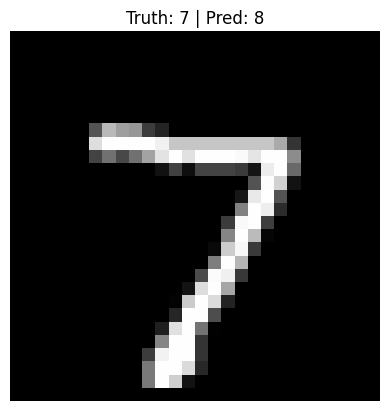

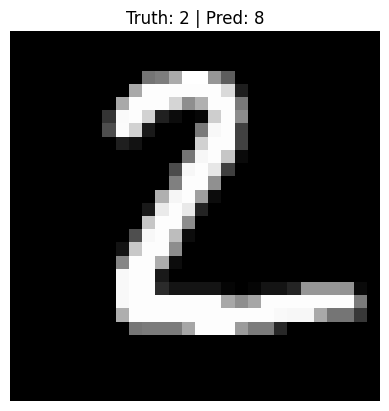

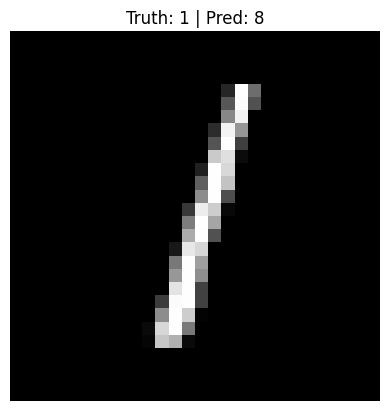

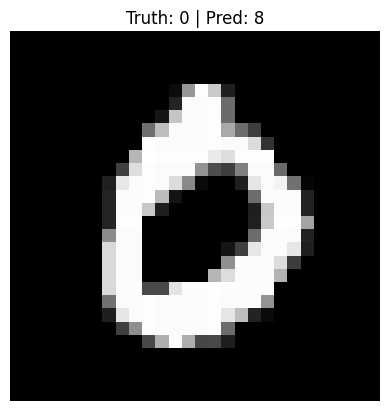

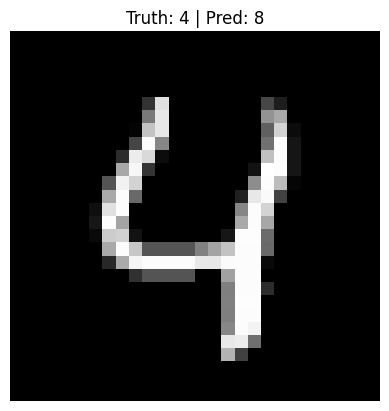

In [22]:
num_to_plot = 5
for i in range(num_to_plot):
    img = test_data[i][0]
    label = test_data[i][1]

    model_pred_logits = model_gpu(img.unsqueeze(dim=0).to(device))
    model_pred_probs = torch.softmax(model_pred_logits, dim = 1)
    model_pred_label = torch.argmax(model_pred_probs, dim = 1)

    plt.figure()
    plt.imshow(img.squeeze(), cmap = 'gray')
    plt.title(f"Truth: {label} | Pred: {model_pred_label.cpu().item()}")
    plt.axis(False)

In [23]:
#11) Plotting confusion matrix

In [24]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.1


In [25]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher
     

0.23.1


In [26]:
from tqdm.auto import tqdm
model_gpu.eval()
y_preds = []
with torch.inference_mode():
    for batch, (X,y) in tqdm(enumerate(test_dataloader)):
        X,y = X.to(device), y.to(device)
        y_pred_logits = model_gpu(X)
        y_pred_labels = torch.argmax(torch.softmax(y_pred_logits, dim = 1), dim = 1)
        y_preds.append(y_pred_labels)
    y_preds = torch.cat(y_preds).cpu()
len(y_preds)

313it [00:00, 361.81it/s]


10000

In [27]:
test_data.targets[:10],y_preds[:10]

(tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]),
 tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8]))

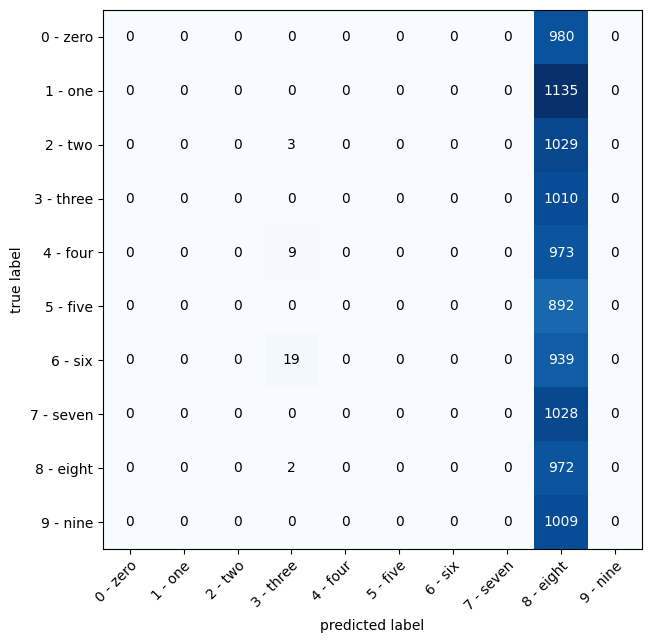

In [30]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix 
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_preds,
                         target=test_data.targets)

# Plot the confusion matrix
fix, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

In [31]:
#12) Create random tensor and pass thru conv2d

In [32]:
random_tensor = torch.rand([1,3,64,64])
random_tensor.shape

torch.Size([1, 3, 64, 64])

In [35]:
conv_layer = nn.Conv2d(in_channels = 3,
                      out_channels = 64,
                      kernel_size = 3,
                      stride = 2,
                      padding = 1)
print(f"Random tensor original shape: {random_tensor.shape}")
random_tensor_via_conv = conv_layer(random_tensor)
print(f"Random tensor through conv layer shape: {random_tensor_via_conv.shape}")

Random tensor original shape: torch.Size([1, 3, 64, 64])
Random tensor through conv layer shape: torch.Size([1, 64, 32, 32])


In [36]:
#13) do predictions on FMNIST

In [37]:
# Download FashionMNIST train & test
from torchvision import datasets
from torchvision import transforms

fashion_mnist_train = datasets.FashionMNIST(root=".",
                                            download=True,
                                            train=True,
                                            transform=transforms.ToTensor())

fashion_mnist_test = datasets.FashionMNIST(root=".",
                                           train=False,
                                           download=True,
                                           transform=transforms.ToTensor())

len(fashion_mnist_train), len(fashion_mnist_test)

100%|██████████| 26.4M/26.4M [00:08<00:00, 3.24MB/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 240kB/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 4.70MB/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 3.21MB/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



(60000, 10000)

In [38]:

# Get the class names of the Fashion MNIST dataset
fashion_mnist_class_names = fashion_mnist_train.classes
fashion_mnist_class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [39]:
# Turn FashionMNIST datasets into dataloaders
from torch.utils.data import DataLoader

fashion_mnist_train_dataloader = DataLoader(fashion_mnist_train,
                                            batch_size=32,
                                            shuffle=True)

fashion_mnist_test_dataloader = DataLoader(fashion_mnist_test,
                                           batch_size=32,
                                           shuffle=False)

len(fashion_mnist_train_dataloader), len(fashion_mnist_test_dataloader)

(1875, 313)

In [42]:
model_2 = MNIST_MODEL(in_units=1,
                      hidden_units=10,
                      out_units=10).to(device)
model_2

MNIST_MODEL(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [45]:


# Setup loss and optimizer
from torch import nn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.01)
     

In [44]:
dummy_x_2 = torch.rand(size=([1, 10, 7, 7]))
dummy_x_2.shape

torch.Size([1, 10, 7, 7])

In [46]:
# Setup metrics
from tqdm.auto import tqdm
from torchmetrics import Accuracy

acc_fn = Accuracy(task = 'multiclass', num_classes=len(fashion_mnist_class_names)).to(device) 

# Setup training/testing loop
epochs = 5
for epoch in tqdm(range(epochs)):
  train_loss, test_loss_total = 0, 0
  train_acc, test_acc = 0, 0 

  ### Training
  model_2.train()
  for batch, (X_train, y_train) in enumerate(fashion_mnist_train_dataloader):
    X_train, y_train = X_train.to(device), y_train.to(device)

    # Forward pass and loss
    y_pred = model_2(X_train)
    loss = loss_fn(y_pred, y_train)
    train_loss += loss
    train_acc += acc_fn(y_pred, y_train)

    # Backprop and gradient descent
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()

  # Adjust the loss/acc (find the loss/acc per epoch)
  train_loss /= len(fashion_mnist_train_dataloader)
  train_acc /= len(fashion_mnist_train_dataloader)

  ### Testing
  model_2.eval()
  with torch.inference_mode():
    for batch, (X_test, y_test) in enumerate(fashion_mnist_test_dataloader):
      X_test, y_test = X_test.to(device), y_test.to(device)

      # Forward pass and loss
      y_pred_test = model_2(X_test)
      test_loss = loss_fn(y_pred_test, y_test)
      test_loss_total += test_loss

      test_acc += acc_fn(y_pred_test, y_test)
  
    # Adjust the loss/acc (find the loss/acc per epoch)
    test_loss /= len(fashion_mnist_test_dataloader)
    test_acc /= len(fashion_mnist_test_dataloader)
    
  # Print out what's happening
  print(f"Epoch: {epoch} | Train loss: {train_loss:.3f} | Train acc: {train_acc:.2f} | Test loss: {test_loss_total:.3f} | Test acc: {test_acc:.2f}")

 20%|██        | 1/5 [00:11<00:45, 11.40s/it]

Epoch: 0 | Train loss: 0.964 | Train acc: 0.65 | Test loss: 184.281 | Test acc: 0.78


 40%|████      | 2/5 [00:22<00:32, 10.98s/it]

Epoch: 1 | Train loss: 0.501 | Train acc: 0.82 | Test loss: 161.513 | Test acc: 0.81


 60%|██████    | 3/5 [00:32<00:21, 10.82s/it]

Epoch: 2 | Train loss: 0.438 | Train acc: 0.84 | Test loss: 142.018 | Test acc: 0.84


 80%|████████  | 4/5 [00:43<00:10, 10.80s/it]

Epoch: 3 | Train loss: 0.408 | Train acc: 0.85 | Test loss: 137.224 | Test acc: 0.85


100%|██████████| 5/5 [00:54<00:00, 10.84s/it]

Epoch: 4 | Train loss: 0.386 | Train acc: 0.86 | Test loss: 130.423 | Test acc: 0.85


In [47]:

# Make predictions with trained model_2
test_preds = []
model_2.eval()
with torch.inference_mode():
  for X_test, y_test in tqdm(fashion_mnist_test_dataloader):
    y_logits = model_2(X_test.to(device))
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_pred_labels = torch.argmax(y_pred_probs, dim=1)
    test_preds.append(y_pred_labels)
test_preds = torch.cat(test_preds).cpu() # matplotlib likes CPU
test_preds[:10], len(test_preds)    

100%|██████████| 313/313 [00:00<00:00, 496.02it/s]


(tensor([9, 2, 1, 1, 0, 1, 4, 6, 5, 7]), 10000)

In [48]:

# Get wrong prediction indexes
import numpy as np
wrong_pred_indexes = np.where(test_preds != fashion_mnist_test.targets)[0]
len(wrong_pred_indexes)

1475

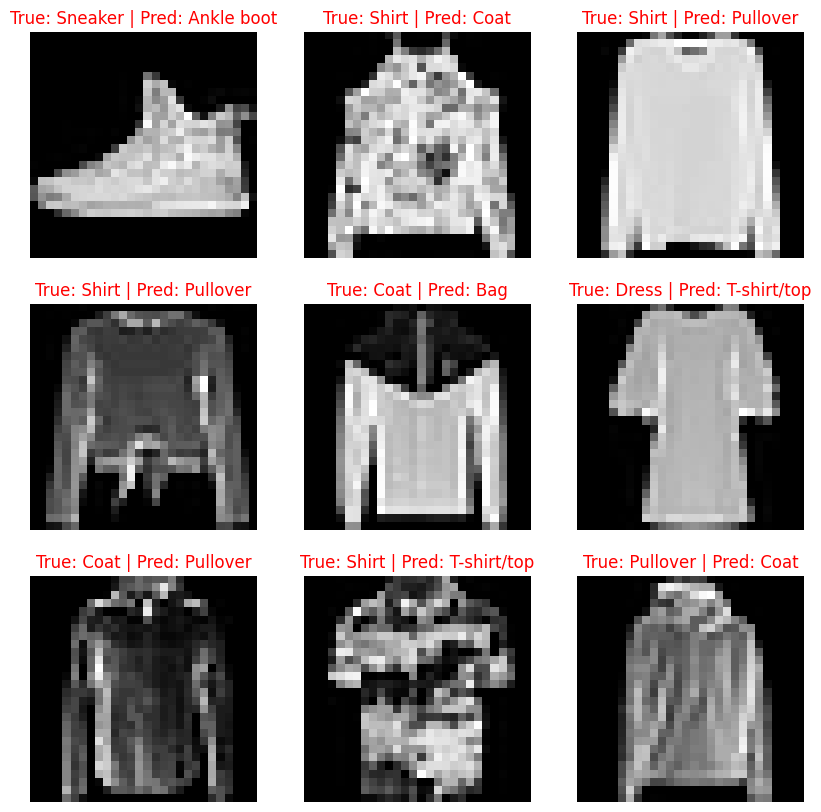

In [49]:
# Select random 9 wrong predictions and plot them
import random
random_selection = random.sample(list(wrong_pred_indexes), k=9)

plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_selection):
  # Get true and pred labels
  true_label = fashion_mnist_class_names[fashion_mnist_test[idx][1]]
  pred_label = fashion_mnist_class_names[test_preds[idx]]

  # Plot the wrong prediction with its original label
  plt.subplot(3, 3, i+1)
  plt.imshow(fashion_mnist_test[idx][0].squeeze(), cmap="gray")
  plt.title(f"True: {true_label} | Pred: {pred_label}", c="r")
  plt.axis(False);